In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from utils.imports import *
from utils.structured import *
from utils.basic_utils import *
from utils.pricing import *
from utils.fundamental import *

pd.options.display.float_format = '{:,.2f}'.format

Loading utils/config.json


In [2]:
# imports
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.validation import column_or_1d
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
%%time
# use the latest saved data for profile and quote info
dates = read_dates('quote')
tgt_date = [dates[-1]] # last date saved in S3

quotes = load_csvs('quote_consol', dates[-1:])
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

Loading file quote/csv/2019-03-18
Loading file summary-categories/assetProfile
CPU times: user 163 ms, sys: 42.5 ms, total: 206 ms
Wall time: 6.26 s


In [4]:
# feature mapping for different datasets
ds_dict = {
    'day_quote': {
        'path': 'quote/csv/',
        'index': 'storeDate',
        'features': [
            'regularMarketChangePercent',
            'averageDailyVolume10Day', 'averageDailyVolume3Month', 'regularMarketVolume', 
            'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent',
            'fiftyTwoWeekHighChangePercent', 'fiftyTwoWeekLowChangePercent', 
            'forwardPE', 'trailingPE', 'priceToBook', 'marketCap', 'trailingAnnualDividendYield', 
            'financialCurrency', 'symbol', ],
        'scale': ['marketCap', ],
        'divide': ('regularMarketVolume', ['averageDailyVolume10Day', 'averageDailyVolume3Month']),
        'outlier': 3, 
    },
    'key_statistics': {
        'path': 'summary-categories/defaultKeyStatistics/',
        'index': 'storeDate',
        'features': [
            'beta', 'earningsQuarterlyGrowth', 
            'enterpriseToEbitda', 'enterpriseToRevenue', 'enterpriseValue', 'forwardPE', 
            'netIncomeToCommon', 'pegRatio', 'priceToBook', 'profitMargins', 
            'shortPercentOfFloat', 'shortRatio', 'heldPercentInsiders', 
            'heldPercentInstitutions', 'symbol', ],
        'scale': ['enterpriseValue', 'netIncomeToCommon', ],
        'outlier': 4, 
    },
    'eps_estimates': {
        'path': 'summary-categories/earningsEstimate/',
        'index': 'storeDate',
        'periods': ['+1q', '+1y',],
        'features': [
            'period', 'growth', 'avg', 'low', 'high', 'symbol', ],
        'pivot_cols': ['growth', 'avg', 'low', 'high'],
        'outlier': 3 },
    'eps_revisions': {
        'path': 'summary-categories/epsRevisions/',
        'index': 'storeDate',
        'periods': ['+1q', '+1y',],        
        'features': [
            'period', 'growth', 'upLast7days', 'upLast30days', 'downLast30days', 
            'symbol', ],
        'pivot_cols': ['growth', 'upLast7days', 'upLast30days', 'downLast30days'],
        'outlier': 3, 
    },
    'eps_trend': {
        'path': 'summary-categories/epsTrend/',
        'index': 'storeDate',
        'periods': ['+1q', '+1y',],        
        'features': [
            'period', 'growth', 
            'current', '7daysAgo', '30daysAgo', '60daysAgo', '90daysAgo', 
            'symbol', ],
        'pivot_cols': ['growth', 'current', '7daysAgo', '30daysAgo', '60daysAgo', '90daysAgo'],
    },
    'fin_data': {
        'path': 'summary-categories/financialData/',
        'index': 'storeDate',
        'features': [
            'currentRatio', 'debtToEquity', 'earningsGrowth', 'ebitda', 
            'ebitdaMargins', 'financialCurrency', 'freeCashflow', 'grossMargins', 
            'grossProfits', 'operatingCashflow', 'operatingMargins', 'profitMargins', 
            'quickRatio', 'recommendationKey', 'recommendationMean', 
            'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 
            'targetHighPrice', 'targetLowPrice', 'targetMeanPrice', 
            'targetMedianPrice', 'totalCash', 'totalDebt', 'totalRevenue', 
            'symbol', ],
        'scale': [
            'freeCashflow', 'operatingCashflow', 'ebitda', 
            'totalCash', 'totalDebt', 'totalRevenue', 'grossProfits', ],
        'perc_price': [
            'targetLowPrice', 'targetMeanPrice', 
            'targetMedianPrice', 'targetHighPrice', ],
        'outlier': 20,
    },
    'spy_trend': {
        'path': 'summary-categories/indexTrend/',
        'index': 'storeDate',
        'features': [
            '0q', '+1q', '0y', '+1y', '+5y', '-5y', 
            'peRatio', 'pegRatio', 'symbol', ]
    },
    'net_purchase': {
        'path': 'summary-categories/netSharePurchaseActivity/',
        'index': 'storeDate',
        'features': [
            'netPercentInsiderShares', 'buyPercentInsiderShares', 'sellPercentInsiderShares', 
            'symbol', ]
    },    
    'rec_trend': {
        'path': 'summary-categories/recommendationTrend/',
        'index': 'storeDate',
        'periods': ['-1m', '-2m'],
        'features': [
            'period', 'strongBuy', 'buy', 'hold', 'sell', 'strongSell', 
            'symbol', ],
        'pivot_cols': ['strongBuy', 'buy', 'hold', 'sell', 'strongSell'],
    },
}

In [5]:
%%time
symbols_list = config['companies']
# px_close = get_mults_pricing(symbols_list)
# save down to drive if refresh pricing
# os.makedirs('tmp', exist_ok=True)
# px_close.to_parquet('tmp/mult-co-px-ds')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs


In [6]:
# last saved pricing from local drive
px_close = pd.read_parquet('tmp/mult-co-px-ds')
px_close.index = px_close.index.date
stacked_px = px_close.stack().to_frame().rename(columns={0: 'close'})
stacked_px.index.set_names(['storeDate', 'symbol'], inplace=True)

look_ahead = 20
y_col = 'fwdReturn' + str(look_ahead)
Y = px_close.pct_change(look_ahead).shift(-look_ahead)
Y = Y[~(Y.isna().all(1))]

In [7]:
# Y[Y.columns[:100]].plot.kde(xlim=(-0.5,0.5), legend=False, color='b', alpha=0.1)

### Dataset creation

In [42]:
# pre-processing pipeline
pre_proc_pipeline = {
    'vectorized': ['day_quote', 'key_statistics', 'eps_estimates'],
    'day_quote': [preproc_divide, preproc_scale, preproc_outlier],
    'key_statistics': [preproc_scale, preproc_outlier],
    'eps_estimates': [df_wide_transform, preproc_eps_estimates, preproc_outlier],
    'eps_revisions': [df_wide_transform, preproc_day_delta, preproc_outlier],
    'eps_trend': [df_wide_transform, preproc_eps_trend],
    'fin_data': [preproc_scale, preproc_perc_price],
    'rec_trend': [df_wide_transform],
}

In [43]:
ticker = ['AAPL']
key = 'eps_estimates'
pre = key.split('_')[0] # append preffix
periods = ['+1q', '+1y',] # forward looking periods only

look_back = 252
path = ds_dict[key]['path']
dates = read_dates(path, '.csv')
load_dates = dates[-look_back:]

context = {    
    'ds_dict': ds_dict[key],
    'pre': pre,
}

In [44]:
# list(set(daily_df.index.unique().date.astype(str)).symmetric_difference(load_dates))

In [45]:
# Load data / appending to local mechanism
dir_loc = 'tmp/'
fname = dir_loc + key
if os.path.isfile(fname):
    daily_df = pd.read_parquet(fname)
    # compare and load missing dates
    missing_dates = list(set(daily_df.index.unique().date.astype(str))\
                         .symmetric_difference(load_dates))
    if len(missing_dates) > 0: # retrieve missing dates
        append_df = get_daily_ts(key, ds_dict, missing_dates)
        daily_df = pd.concat([daily_df, append_df], axis=0) # append to daily
        # daily_df.drop_duplicates(inplace=True)
        daily_df.to_parquet('tmp/' + key) # and persist to drive for next time
else:
    # file does not exist, retrieves all dates
    daily_df = get_daily_ts(key, ds_dict, load_dates)
    # Make index a flat date, easier to index
    # save down to drive if refresh pricing
    os.makedirs(dir_loc, exist_ok=True)
#     daily_df.drop_duplicates(inplace=True)
    daily_df.to_parquet(fname)
daily_df.index = daily_df.index.date
daily_df.shape

(328068, 6)

In [46]:
# helps check data integrity / storage related issues
# print(date.fromtimestamp(1551139200))
# daily_df.groupby(by=daily_df.index)['symbol'].count()

In [74]:
%%time
# pre-process entire datasets in one shot or by company
# applies functions in pipeline to datasets
super_list = []

if key not in pre_proc_pipeline['vectorized']:
    for ticker in symbols_list:
#         co_df = daily_df.loc[(slice(None), ticker), :] # for using multi-index
        co_df = daily_df.loc[daily_df.symbol == ticker, :]
        if not len(co_df): continue
        context['hist_price'] = px_close.loc[co_df.index, ticker]
        # context['hist_price'] = stacked_px.loc[(co_df.index.levels[0].date, ticker), :] # for using multi-index
        proc_df = preproc_df(co_df, key, pre_proc_pipeline, context)
        super_list.append(proc_df)
    processed_df = pd.concat(super_list, axis=0)
else:
    processed_df = preproc_df(daily_df, key, pre_proc_pipeline, context)

CPU times: user 6.93 s, sys: 1.23 s, total: 8.16 s
Wall time: 1.93 s


In [75]:
# processed_df.loc[(slice(None), 'AAPL'), :].head()
# processed_df.loc[processed_df.symbol == 'AAPL', :].duplicated().count()
# processed_df.loc[processed_df.symbol == 'AAPL', :].describe().T
# processed_df.duplicated().count()
processed_df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
+1q_avg,"48,901.00",nan,nan,-inf,0.00,0.00,0.00,inf
+1q_growth,"46,950.00",-0.00,0.06,-1.60,0.00,0.00,0.00,1.61
+1q_high,"48,940.00",nan,nan,-inf,0.00,0.00,0.00,inf
+1q_low,"48,693.00",nan,nan,-inf,0.00,0.00,0.00,inf
+1y_avg,"49,769.00",nan,nan,-inf,0.00,0.00,0.00,inf
+1y_growth,"48,399.00",0.00,0.06,-2.62,0.00,0.00,0.00,2.51
+1y_high,"49,769.00",nan,nan,-inf,0.00,0.00,0.00,inf
+1y_low,"49,695.00",nan,nan,-inf,0.00,0.00,0.00,inf
+5y_growth,"50,817.00",-0.00,0.01,-0.16,0.00,0.00,0.00,0.16
-5y_growth,"45,168.00",0.00,0.01,-0.15,0.00,0.00,0.00,0.15


In [78]:
# temporary workaround, should load with with indices
if processed_df.index.is_mixed(): processed_df.reset_index(level=1, drop=False, inplace=True)

In [79]:
#### shrinks forward returns ds to dates from processed df, faster execution
Y_df = Y.loc[processed_df.index.unique().sortlevel()[0], :]
Y_df = Y_df[~Y_df.isna().all(1).values]

# reshapes to include symbol in index in additional to date
Y_df = Y_df.stack().to_frame().rename(columns={0: y_col})
Y_df.index.set_names(['storeDate', 'symbol'], inplace=True)
# Y_df.loc[(slice(None), 'AAPL'), :].tail() # example to query using multi-index

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [80]:
# re-index processed df on storeDate and symbol to have similar indices
processed_df.index.set_names(['storeDate'], inplace=True)
processed_df.reset_index(inplace=True)
processed_df.set_index(['storeDate', 'symbol'], inplace=True)
# processed_df.reset_index(level=1) # to get back to date only, if needed

# add Y values to processed df fast without having to loop
processed_df.loc[:, y_col] = Y_df.loc[:, y_col]

# add sectors columns
processed_df.loc[:, 'sector'] = processed_df.reset_index()['symbol'].map(
    profile.sector.to_dict()).values

processed_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [81]:
# saved down processed df
os.makedirs('tmp', exist_ok=True)
processed_df.to_parquet('tmp/co-fund-processed-' + key)

In [82]:
# pick up already processed df
processed_df = pd.read_parquet('tmp/co-fund-processed-' + key)
print(processed_df.info(verbose=False))

# processed_df.drop_duplicates(subset=[y_col]).describe()
df_large = processed_df.dropna(subset=[y_col, 'sector'])
df_large.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 53774 entries, (2019-02-07 00:00:00, 0700) to (2019-03-18 00:00:00, ZUO)
Columns: 20 entries, +1q_avg to sector
dtypes: float64(19), object(1)
memory usage: 8.4+ MB
None


(29601, 20)

### Pre-processing

In [83]:
cuts = { '1d': [-1, -0.1, -.02, .02, .1, 1.] }
cut_range = cuts['1d']
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

In [84]:
# Trims dataset in case it's too large for experimentation
# Reduce dataset for experimentation
# Note that experiment dataset is not stratified
exp_perc = 99e-2
_, df_raw = train_test_split(df_large, test_size=exp_perc, shuffle=False, )

df_raw.dropna(subset=[y_col],  inplace=True)
df_raw[y_col] = discret_rets(df_raw[y_col], cut_range, fwd_ret_labels)

# df_raw.loc[:, y_col] = df_raw[y_col].astype(str)

y_col_dist = sample_wgts(df_raw[y_col], fwd_ret_labels)
(y_col_dist[fwd_ret_labels]).round(3)

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


bear      0.20
short     0.27
neutral   0.15
long      0.23
bull      0.15
Name: fwdReturn20, dtype: float64

In [85]:
df_raw.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
+1q_avg,"26,391.00",NaN,NaN,NaN,-0.01,0.46,-24.00,0.00,0.00,0.00,41.23
+1q_growth,"25,597.00",NaN,NaN,NaN,-0.00,0.05,-1.53,0.00,0.00,0.00,1.56
+1q_high,"26,425.00",NaN,NaN,NaN,-0.01,0.49,-40.00,0.00,0.00,0.00,45.67
+1q_low,"26,266.00",NaN,NaN,NaN,-0.01,0.53,-19.85,0.00,0.00,0.00,43.75
+1y_avg,"27,064.00",NaN,NaN,NaN,-0.01,0.77,-12.68,0.00,0.00,0.00,112.67
+1y_growth,"26,308.00",NaN,NaN,NaN,-0.00,0.05,-2.61,0.00,0.00,0.00,1.80
+1y_high,"27,064.00",NaN,NaN,NaN,-0.01,0.85,-33.00,0.00,0.00,0.00,125.67
+1y_low,"27,028.00",NaN,NaN,NaN,-0.01,0.69,-10.00,0.00,0.00,0.00,94.00
+5y_growth,"28,396.00",NaN,NaN,NaN,0.00,0.01,-0.16,0.00,0.00,0.00,0.15
-5y_growth,"24,511.00",NaN,NaN,NaN,0.00,0.01,-0.13,0.00,0.00,0.00,0.14


In [87]:
key

'eps_estimates'

In [ ]:
# turn categorical fields into one-hot encoder dummies
categorical_dict = {
    'day_quote': ['financialCurrency', 'sector'],
    'key_statistics': ['sector'],
    'fin_data': ['financialCurrency', 'recommendationKey', 'sector'],        
    'eps_estimates': ['sector'],
}

if key in categorical_dict:
    for col in categorical_dict[key]:
        df_raw = dummy_col(df_raw, col, shorten=True)

df_raw.describe(include='all').T

In [89]:
excl_list = [] # drop unneeded columns
df_raw.drop(columns=excl_list, inplace=True, errors='ignore')
df_raw.shape

(29305, 27)

In [90]:
df_raw.columns

Index(['+1q_avg', '+1q_growth', '+1q_high', '+1q_low', '+1y_avg', '+1y_growth',
       '+1y_high', '+1y_low', '+5y_growth', '-5y_growth', '0q_avg',
       '0q_growth', '0q_high', '0q_low', '0y_avg', '0y_growth', '0y_high',
       '0y_low', 'fwdReturn20', '^BASI_MATE', '^COMM_SERV', '^CONS_CYCL',
       '^CONS_DEFE', '^FINA_SERV', '^HEAL', '^INDU', '^TECH'],
      dtype='object')

In [91]:
drop_dates = True

if drop_dates: df_raw.reset_index(drop=True, inplace=True)
else: 
    df_raw.reset_index(inplace=True)
    df_raw.rename({'index': 'obsDate'}, axis=1, inplace=True)
    add_datepart(df_raw, 'obsDate')
    
# df_raw[[x for x in df_raw.columns if 'obs' in x]]
# exp_log['drop_dates'] = drop_dates

### Train models

In [92]:
# Mean based imputer
imputer_on, scaler_on = True, True
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
scaler = StandardScaler()

df_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
pre_ml_df = df_raw.copy()
pre_ml_df.dropna(subset=[y_col], inplace=True)
pre_ml_df.loc[:, y_col] = pre_ml_df[y_col].astype(str)
X_cols = excl(pre_ml_df.columns, [y_col])

if imputer_on: pre_ml_df.loc[:, X_cols] = imputer.fit_transform(pre_ml_df[X_cols])
else: pre_ml_df.dropna(inplace=True)
if scaler_on: pre_ml_df.loc[:, X_cols] = scaler.fit_transform(pre_ml_df[X_cols])

X, y = pre_ml_df.drop(columns=y_col), pre_ml_df[y_col]

# sample_weight = np.random.RandomState(42).rand(y.shape[0])
# X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X, y, sample_weight, test_size=.20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23439, 26), (5860, 26), (23439,), (5860,))

In [96]:
%%time

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

# RandomForestClassifier
params = {
    'n_estimators': 100, 
    'max_features': 'auto', 
    'random_state': 1,
    'max_depth': None, 
    'min_samples_split': 2, 
    'n_jobs': -1}

clf = RandomForestClassifier(**params)
clf.fit(X_train, y_train)

scores = clf.score(X_train, y_train), clf.score(X_test, y_test)
print(scores)

(0.43444686206749433, 0.30255972696245736)
CPU times: user 3.89 s, sys: 143 ms, total: 4.04 s
Wall time: 735 ms


In [94]:
%%time
# ExtraTreesClassifier
clf = ExtraTreesClassifier(
    n_estimators=100, max_depth=None, 
    min_samples_split=2, random_state=1, n_jobs=-1)

clf.fit(X_train, y_train)
scores = clf.score(X_train, y_train), clf.score(X_test, y_test)
print(scores)

(0.43444686206749433, 0.30392491467576793)
CPU times: user 6.49 s, sys: 165 ms, total: 6.66 s
Wall time: 934 ms


In [95]:
%%time
# MLPClassifier
params = {
    'solver': 'lbfgs', 
    'max_iter': 200, 
    'activation': 'relu', 
    'alpha': 0.01, 
    'learning_rate' : 'adaptive', # ['constant', 'adaptive']
    'hidden_layer_sizes': 45, # np.arange(5, 50, 10)
    'random_state': 0 } # np.arange(0, 10, 2)

clf = MLPClassifier(**params)

clf.fit(X_train, y_train)
scores = clf.score(X_train, y_train), clf.score(X_test, y_test)
print(scores)

(0.30440718460685184, 0.28481228668941977)
CPU times: user 14.3 s, sys: 2.05 s, total: 16.4 s
Wall time: 2.87 s


#### Metrics

Feature ranking:
4 feature +1y_avg (0.10370985773505606)
5 feature +1y_growth (0.08180155892264394)
8 feature +5y_growth (0.07456362928381019)
9 feature -5y_growth (0.06953807595074372)
14 feature 0y_avg (0.05664747673038172)
15 feature 0y_growth (0.05148283158771128)
0 feature +1q_avg (0.05094621713054244)
1 feature +1q_growth (0.0468108533906798)
11 feature 0q_growth (0.04342246144148204)
10 feature 0q_avg (0.043378082973564026)
17 feature 0y_low (0.04151595079350457)
16 feature 0y_high (0.04080883871121487)
6 feature +1y_high (0.04020802881529201)
13 feature 0q_low (0.038598964247975126)
7 feature +1y_low (0.038432713183216595)
12 feature 0q_high (0.03666802926218479)
2 feature +1q_high (0.03559091609858096)
3 feature +1q_low (0.03419068488048324)
25 feature ^TECH (0.017658745345232808)
20 feature ^CONS_CYCL (0.01570214381965799)
23 feature ^HEAL (0.01525096912608132)
21 feature ^CONS_DEFE (0.008747159077879091)
24 feature ^INDU (0.006174216151440201)
22 feature ^FINA_SERV (0.005062

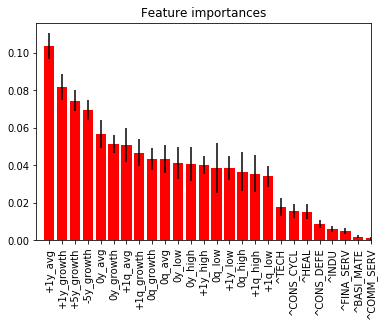

In [97]:
show_fi(clf, X, 25)

In [98]:
print('Confussion Matrix\n', confusion_matrix(clf.predict(X_test), y_test, labels=fwd_ret_labels))

Confussion Matrix
 [[ 224  172   82  121  116]
 [ 805 1174  633  911  468]
 [  19   36   29   35   22]
 [  51  115   75  145   81]
 [  71   79   63  132  201]]


In [99]:
print('Classificaton report\n', classification_report(clf.predict(X_test), y_test, target_names=fwd_ret_labels))

Classificaton report
               precision    recall  f1-score   support

        bear       0.19      0.31      0.24       715
       short       0.23      0.37      0.28       546
     neutral       0.11      0.31      0.16       467
        long       0.03      0.21      0.06       141
        bull       0.74      0.29      0.42      3991

   micro avg       0.30      0.30      0.30      5860
   macro avg       0.26      0.30      0.23      5860
weighted avg       0.56      0.30      0.36      5860



In [100]:
log_loss(y_test, clf.predict_proba(X_test))

1.7982311948212732

#### Gridsearches

In [2111]:
np.arange(10, X.shape[1], int(X.shape[1]*.25))

array([10, 18, 26])

In [2114]:
%%time
# GridSearchCV for RandomForestClassifier
parameters = {
    'n_estimators': [10, 40, 80], 
    'max_features': np.arange(10, X.shape[1], int(X.shape[1]*.25)), 
    'random_state': np.arange(1, 10, 3)}

# parameters = {
#     'n_estimators': [40], 
#     'max_features': [30], 
#     'random_state': [1]}

clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train), clf.score(X_test, y_test))
print(clf.best_params_)

0.9754060712347071 0.605878423513694
{'max_features': 30, 'n_estimators': 40, 'random_state': 1}
CPU times: user 6.9 s, sys: 263 ms, total: 7.16 s
Wall time: 14 s


In [2137]:
%%time
# GridSearchCV for MLPClassifier

parameters = {
    'solver': ['lbfgs'], # ['lbfgs', 'sgd', 'adam']
    'max_iter': [200], # [200, 400, 600]
    'activation': ['relu'], # ['logistic', 'tanh', 'relu']
    'alpha': 10.0 ** -np.arange(2, 5, 1), # 10.0 ** -np.arange(2, 5, 1)
    'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
    'hidden_layer_sizes': np.arange(5, 50, 10), # np.arange(5, 50, 10)
    'random_state': np.arange(0, 10, 3)} # np.arange(0, 10, 2)

parameters = {
    'solver': ['lbfgs'], 
    'max_iter': [200], 
    'activation': ['relu'], 
    'alpha': [0.01], 
    'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
    'hidden_layer_sizes': [ 45 ], # np.arange(5, 50, 10)
    'random_state': [0] } # np.arange(0, 10, 2)

clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

scores = clf.score(X_train, y_train), clf.score(X_test, y_test)
print(scores)
print(clf.best_params_)

CPU times: user 18.6 s, sys: 2.75 s, total: 21.4 s
Wall time: 10.3 s


### Feature construction

In [538]:
ticker = ['AAPL']
key = 'key_statistics'
pre = key.split('_')[0] # append preffix
periods = ['+1q', '+1y',] # forward looking periods only

In [539]:
%%time
# retrieves dataset for historical dates
daily_df = get_daily_ts(key, ds_dict, 10)
# Make index a flat date, easier to index
daily_df.index = daily_df.index.date

Loading file summary-categories/defaultKeyStatistics/2019-03-01
Loading file summary-categories/defaultKeyStatistics/2019-03-04
Loading file summary-categories/defaultKeyStatistics/2019-03-05
Loading file summary-categories/defaultKeyStatistics/2019-03-06
Loading file summary-categories/defaultKeyStatistics/2019-03-07
Loading file summary-categories/defaultKeyStatistics/2019-03-08
Loading file summary-categories/defaultKeyStatistics/2019-03-11
Loading file summary-categories/defaultKeyStatistics/2019-03-12
Loading file summary-categories/defaultKeyStatistics/2019-03-13
Loading file summary-categories/defaultKeyStatistics/2019-03-14
CPU times: user 385 ms, sys: 58.2 ms, total: 443 ms
Wall time: 4.28 s


In [540]:
sel_co = False
if sel_co:
    active_df = daily_df[daily_df.symbol.isin(ticker)].copy()
else: 
    active_df = daily_df[daily_df.symbol.isin(symbols_list)].copy()
active_df.describe(include='all').T.sort_values(by='mean')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
pegRatio,"11,105.00",NaN,NaN,NaN,-3.50,267.47,"-12,573.70",0.98,1.60,2.58,741.48
heldPercentInsiders,"12,050.00",NaN,NaN,NaN,0.05,0.12,0.00,0.00,0.01,0.04,0.93
shortPercentOfFloat,"9,718.00",NaN,NaN,NaN,0.06,0.08,0.00,0.02,0.04,0.07,1.04
profitMargins,"12,071.00",NaN,NaN,NaN,0.11,0.22,-2.80,0.05,0.10,0.19,1.98
heldPercentInstitutions,"12,050.00",NaN,NaN,NaN,0.76,0.32,0.00,0.71,0.87,0.96,2.23
beta,"11,760.00",NaN,NaN,NaN,1.13,0.59,-1.02,0.75,1.10,1.46,4.21
earningsQuarterlyGrowth,"8,116.00",NaN,NaN,NaN,2.85,157.24,-0.99,-0.48,0.02,0.69,"14,155.00"
shortRatio,"11,861.00",NaN,NaN,NaN,4.80,4.11,0.00,2.22,3.62,5.99,51.73
enterpriseToRevenue,"10,787.00",NaN,NaN,NaN,5.73,23.57,-6.45,1.56,3.15,5.53,569.49
priceToBook,"11,614.00",NaN,NaN,NaN,5.92,21.88,0.02,1.63,2.76,5.39,738.22


In [541]:
# active_df.plot()
active_df.tail().T

,2019-03-14,2019-03-14,2019-03-14,2019-03-14,2019-03-14
52WeekChange,0.71638656,-0.102831066,0.2583171,0.14452708,Infinity
beta,1.51,1.56,0.71,0.67,NaN
earningsQuarterlyGrowth,NaN,0.84,0.04,3.26,NaN
enterpriseToEbitda,-85.52,NaN,NaN,23.25,-38.32
enterpriseToRevenue,14.78,4.89,NaN,8.69,10.83
enterpriseValue,"8,851,857,408.00","13,786,930,176.00","15,180,584,960.00","50,590,412,800.00","2,392,433,152.00"
forwardPE,125.70,10.20,19.92,24.79,-53.41
netIncomeToCommon,"-131,084,000.00","845,000,000.00",NaN,"1,428,000,000.00","-70,746,000.00"
pegRatio,5.52,0.86,51.27,1.84,NaN
priceToBook,21.49,1.31,2.99,21.12,16.26


In [542]:
# pre-processing pipeline
pre_proc_pipeline = {
    'day_quote': [preproc_divide, preproc_scale, preproc_outlier],
    'key_statistics': [preproc_scale, preproc_outlier],
    'eps_estimates': [df_wide_transform, preproc_eps_estimates],
    'eps_revisions': [df_wide_transform, preproc_day_delta],
    'eps_trend': [df_wide_transform, preproc_eps_trend],
    'fin_data': [preproc_scale_financials, preproc_perc_price],
}

context = {
    'ds_dict': ds_dict,
    'key': key,
    'pre': pre,
    'periods': periods,
    'hist_price': px_close.loc[wide_df.index, ticker]
}

processed_df = active_df.copy()
if key in pre_proc_pipeline:
    for fn in pre_proc_pipeline[key]: 
        processed_df = fn(processed_df, context)
processed_df.replace([np.inf, -np.inf], np.nan, inplace=True)

processed_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
52WeekChange,12071,11757,Infinity,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
beta,"11,760.00",NaN,NaN,NaN,1.13,0.59,-1.02,0.75,1.10,1.46,4.21
earningsQuarterlyGrowth,"8,116.00",NaN,NaN,NaN,2.85,157.24,-0.99,-0.48,0.02,0.69,"14,155.00"
enterpriseToEbitda,"9,961.00",NaN,NaN,NaN,15.66,87.08,"-1,220.77",8.86,12.62,18.75,"1,835.36"
enterpriseToRevenue,"10,787.00",NaN,NaN,NaN,5.73,23.57,-6.45,1.56,3.15,5.53,569.49
enterpriseValue,"12,054.00",NaN,NaN,NaN,0.01,0.04,-0.07,0.00,0.00,0.01,1.00
forwardPE,"11,316.00",NaN,NaN,NaN,21.48,89.33,-401.42,10.99,15.66,22.60,"3,114.00"
netIncomeToCommon,"10,818.00",NaN,NaN,NaN,0.02,0.06,-0.35,0.00,0.01,0.02,1.00
pegRatio,"11,105.00",NaN,NaN,NaN,-3.50,267.47,"-12,573.70",0.98,1.60,2.58,741.48
priceToBook,"11,614.00",NaN,NaN,NaN,5.92,21.88,0.02,1.63,2.76,5.39,738.22


In [543]:
preproc_outlier(processed_df, context).describe().T

,count,mean,std,min,25%,50%,75%,max
beta,"11,299.00",1.12,0.58,-1.02,0.74,1.10,1.45,4.21
earningsQuarterlyGrowth,"7,976.00",0.87,4.46,-0.99,-0.48,0.02,0.67,91.70
enterpriseToEbitda,"9,514.00",14.94,13.32,-97.37,9.11,12.58,18.36,99.89
enterpriseToRevenue,"10,340.00",4.24,4.73,-6.45,1.53,3.04,5.11,65.22
enterpriseValue,"11,539.00",0.01,0.04,-0.07,0.00,0.00,0.01,1.00
forwardPE,"10,811.00",17.83,13.18,-92.09,11.01,15.43,21.82,97.65
netIncomeToCommon,"10,371.00",0.02,0.07,-0.35,0.00,0.01,0.02,1.00
pegRatio,"10,660.00",2.62,7.93,-91.77,1.00,1.60,2.54,99.95
priceToBook,"11,115.00",4.91,7.86,0.02,1.59,2.70,5.08,99.38
profitMargins,"11,556.00",0.12,0.21,-2.80,0.05,0.10,0.19,1.55


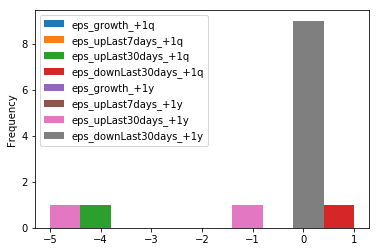

In [342]:
processed_df.plot.hist()

#### Metrics

### Other

#### Vectorized long to wide

In [33]:
df = df_wide_transform(daily_df, context)
df1 = preproc_eps_estimates(df, context)
df2 = preproc_outlier(df1, context)

In [ ]:
df2.loc[(slice(None), 'AAPL'), :].plot()

In [1611]:
df1 = df.loc[(slice(None),'AAPL'), :]
# growth_cols = filter_cols(df1.columns, 'growth')
# other_cols = excl(df1.columns, growth_cols)
# df1.loc[df1.index, growth_cols] = day_delta(df1[growth_cols], 1)
# df1.loc[df1.index, other_cols] = df1[other_cols].pct_change()

df2 = preproc_eps_estimates(df.sort_index(level=1), context)

In [ ]:
df.sort_index(level=1)

In [ ]:
df2.loc[(slice(None), symbols_list[3:40]), growth_cols].describe().T

#### Faster way to perform price division? WIP

In [1420]:
daily_df.index.set_names('storeDate', inplace=True)

In [1421]:
# df.tail()
stacked_px.head()

close
storeDate  symbol       
2004-03-08 FBR     13.80
2004-03-09 FBR     13.74
           SHPG    31.40
2004-03-10 FBR     13.32
           SHPG    30.20

In [1422]:
f_cols = filter_cols(daily_df.columns, 'target')
df = daily_df.reset_index().set_index(['storeDate', 'symbol'])

In [1430]:
# df[f_cols] / stacked_px['close']
# stacked_px.loc[df.index, :]
stacked_px = stacked_px.loc[df.index.unique().sortlevel()[0], :]
stacked_px = stacked_px[~stacked_px.isna().all(1).values]

In [ ]:
# df.loc[:, f_cols] / stacked_px.loc[:, 'close']
# stacked_px.loc[:, 'close']

#### Experimenting to cleanse duplicated rows

In [907]:
# tailored remove duplicated rows
# ex_cols = [x for x in list(processed_df.columns) if 'target' in x] + [y_col]
# filter_cols = excl(processed_df.columns, ex_cols)
# processed_df.drop_duplicates(subset=filter_cols, inplace=True)

In [908]:
# generic remove duplicates
# processed_df.drop_duplicates(inplace=True) # less duplicated describe

#### Long to wide transformations for recommendation trend / vectorized

In [369]:
daily_df.index.set_names('storeDate', inplace=True)
daily_df = daily_df.reset_index().set_index(['storeDate', 'symbol', 'period'])

In [439]:
cols = pd.Index(['strongBuy','buy','hold','sell','strongSell'], name='cols')
ldata = daily_df.reindex(columns=cols).stack().reset_index().rename(columns={0: 'value'})
# ldata.tail()
pivoted = ldata.pivot_table(index=['storeDate', 'symbol'], columns=['period', 'cols'], values=['value'])

In [518]:
# 0m and -3m month have std deviation = 0 -- no changes
# pivoted.loc[(slice(None), 'AMZN'), :].sort_index(ascending=False).std()
# pivoted.loc[(slice(None), 'TSLA'), (slice(None), ['-3m', '-2m', '-1m'], 'strongBuy')].sort_index(ascending=False).plot()
flat_df = pd.DataFrame(pivoted.loc[(slice(None), ), (slice(None), ['-2m', '-1m'])].to_records())

In [559]:
flat_df.head()

,storeDate,symbol,"('value', '-1m', 'buy')","('value', '-1m', 'hold')","('value', '-1m', 'sell')","('value', '-1m', 'strongBuy')","('value', '-1m', 'strongSell')","('value', '-2m', 'buy')","('value', '-2m', 'hold')","('value', '-2m', 'sell')","('value', '-2m', 'strongBuy')","('value', '-2m', 'strongSell')"
0,2018-09-07,A,4.00,3.00,nan,7.00,nan,5.00,2.00,nan,6.00,nan
1,2018-09-07,AAPL,19.00,7.00,nan,11.00,nan,19.00,9.00,nan,10.00,nan
2,2018-09-07,ABMD,3.00,2.00,nan,5.00,nan,2.00,1.00,nan,6.00,nan
3,2018-09-07,ADBE,13.00,6.00,nan,11.00,0.00,14.00,4.00,nan,11.00,1.00
4,2018-09-07,ADP,nan,15.00,nan,2.00,0.00,nan,15.00,nan,2.00,1.00


In [1662]:
col_mapper = lambda cols: {x:'_'.join(strips(x, chars, ',')) for x in cols if 'value' in x}

def strips(s, l, splt): 
    for r in l: s = s.replace(r, '')
    return s.split(splt)[1:]
test = '(value, -1m, buy)'
chars = list(")(' ")
strips(test, chars, ',')
col_mapper([test])

{'(value, -1m, buy)': '-1m_buy'}

In [1663]:
[strips(x, chars) for x in flat_df.columns if 'value' in x]

[]

#### Date and minute based time analysis

In [1007]:
freq = '1d'

In [1008]:
# s1, s2 = '1810.HK', 'AAPL'
group_pricing = pd.DataFrame()
df1 = get_symbol_pricing(s1, freq, ['close'])
df2 = get_symbol_pricing(s2, freq, ['close'])
group_pricing = pd.DataFrame(df1)
# group_pricing.loc[:, s2] = df2
group_pricing = pd.concat([group_pricing, df2], axis=1)
group_pricing.describe()
# group_pricing

,close,close
count,164.00,"3,775.00"
mean,14.24,66.80
std,2.88,56.49
min,9.70,1.81
25%,12.19,16.67
50%,13.59,54.28
75%,16.51,106.82
max,21.55,232.07


In [850]:
path = config['pricing_path'].format(freq)
data_dict = json_load(path + json_ext.format(ticker))

tz = data_dict['meta']['exchangeTimezoneName']
df = build_px_struct(data_dict, freq)

adjClose = data_dict['indicators']['adjclose'][0] if 'adjclose' in  data_dict['indicators'] else 0
close = data_dict['indicators']['quote'][0]
data_dict.keys(), data_dict['indicators'].keys()

(dict_keys(['meta', 'timestamp', 'indicators']), dict_keys(['quote']))

In [916]:
df.index.date

array([datetime.date(2019, 2, 28), datetime.date(2019, 2, 28),
       datetime.date(2019, 2, 28), ..., datetime.date(2019, 3, 6),
       datetime.date(2019, 3, 6), datetime.date(2019, 3, 6)], dtype=object)

In [851]:
dates = pd.to_datetime(
        data_dict['timestamp'], 
        unit='s', infer_datetime_format=True)
# dates = dates.astype(f'datetime64[ns, {tz}]')
# dates.tz_convert('America/New_York')
# dates = dates.tz_localize('America/New_York')
dates.floor('d' if freq == '1d' else 'min')

DatetimeIndex(['2019-02-28 14:30:00', '2019-02-28 14:31:00',
               '2019-02-28 14:32:00', '2019-02-28 14:33:00',
               '2019-02-28 14:34:00', '2019-02-28 14:35:00',
               '2019-02-28 14:36:00', '2019-02-28 14:37:00',
               '2019-02-28 14:38:00', '2019-02-28 14:39:00',
               ...
               '2019-03-06 20:50:00', '2019-03-06 20:51:00',
               '2019-03-06 20:52:00', '2019-03-06 20:53:00',
               '2019-03-06 20:54:00', '2019-03-06 20:55:00',
               '2019-03-06 20:56:00', '2019-03-06 20:57:00',
               '2019-03-06 20:58:00', '2019-03-06 20:59:00'],
              dtype='datetime64[ns]', length=1950, freq=None)

In [829]:
df.tail(5)

,high,low,open,close,adjclose,volume
2019-03-06 20:55:00,174.72,174.60,174.66,174.71,0,"148,802.00"
2019-03-06 20:56:00,174.73,174.67,174.67,174.71,0,"37,980.00"
2019-03-06 20:57:00,174.72,174.65,174.71,174.65,0,"70,312.00"
2019-03-06 20:58:00,174.80,174.64,174.65,174.76,0,"105,856.00"
2019-03-06 20:59:00,174.82,174.46,174.74,174.51,0,"385,081.00"


In [1018]:
freq = '1d'

In [1019]:
%time px_close = get_mults_pricing(symbols_list[:10], freq);

Retrieved pricing for 0700.HK
Retrieved pricing for 1810.HK
Retrieved pricing for 3690.HK
Retrieved pricing for 9984.T
Retrieved pricing for A
Retrieved pricing for AAL
Retrieved pricing for AAN
Retrieved pricing for AAON
Retrieved pricing for AAP
Retrieved pricing for AAPL
CPU times: user 1.05 s, sys: 45.5 ms, total: 1.1 s
Wall time: 3.91 s


In [1022]:
# [px_close[x].dropna().tail() for x in px_close.columns]
px_close.describe()
# px_close.tail()

,0700.HK,0700.HK,1810.HK,3690.HK,9984.T,A,AAL,AAN,AAON,AAP,AAPL
count,"3,634.00","3,634.00",164.00,111.00,"3,743.00","3,775.00","3,382.00","3,775.00","1,258.00","3,775.00","3,775.00"
mean,94.03,94.03,14.24,54.89,"4,406.54",33.28,26.97,23.86,28.76,81.72,66.80
std,115.76,115.76,2.88,7.61,"2,785.93",15.49,17.32,10.35,6.93,49.29,56.49
min,0.68,0.68,9.70,41.20,650.00,8.90,1.76,9.33,16.97,22.10,1.81
25%,9.51,9.51,12.19,48.45,"2,148.00",22.63,9.12,14.67,22.29,39.16,16.67
50%,40.18,40.18,13.59,55.00,"2,960.00",27.83,30.26,23.71,28.15,66.07,54.28
75%,142.08,142.08,16.51,59.82,"7,127.50",40.84,42.34,29.12,35.06,126.80,106.82
max,474.60,474.60,21.55,72.65,"11,470.00",81.24,62.95,55.45,43.83,200.38,232.07


In [1023]:
f'Ticker: {ticker}'

'Ticker: AAPL'

In [1024]:
px = get_symbol_pricing(ticker, freq)
px.close.tail()

2019-02-28 00:00:00-05:00   173.15
2019-03-01 00:00:00-05:00   174.97
2019-03-04 00:00:00-05:00   175.85
2019-03-05 00:00:00-05:00   175.53
2019-03-06 00:00:00-05:00   174.52
Name: close, dtype: float64

#### Retrieve datasets from S3

In [1860]:
# # %%time
# # OLD VERSION: retrieves dataset for historical dates
# daily_df = get_daily_ts(key, ds_dict, load_dates)
# # Make index a flat date, easier to index
# daily_df.index = daily_df.index.date
# # save down to drive if refresh pricing
# os.makedirs('tmp', exist_ok=True)
# daily_df.to_parquet('tmp/' + key)

In [1996]:
# daily_df = pd.read_parquet('tmp/' + key)

#### Double check no duplicates

In [ ]:
# daily_df.describe()
daily_df[daily_df.symbol.isin(symbols_list)].reset_index()\
    .groupby(by=['index'])['symbol'].count().sort_index()

In [1795]:
date_str = "2018-10-03"
datetime.fromtimestamp(1538352000.0)

In [ ]:
df = daily_df.loc[date_str, :]
df.count(), df.symbol.unique().shape, df.iloc[-1]

In [ ]:
df = pd.read_csv(date_str + '.csv', parse_dates=True)
df.describe(include='all').T
# df.drop_duplicates(subset=['symbol'], inplace=True)
# df.to_csv(date_str + '.csv', index=False, index_label=False)

#### Multi-index slicing

In [1573]:
# Multi-index slicing
# stacked_px.loc[(slice(None), ticker), :]
# us_df.loc[daily_df.loc[(slice(None), ticker), :].index, :]
# daily_df.loc[(slice(None), ticker), :].index.levels[0]
# us_df.loc[(slice(None), ticker), :]
# px_close[ticker]
# daily_df.index.levels[1].unique()
# Y_df.index.levels[1].unique()

# idx = pd.IndexSlice
# daily_df.loc[idx[:, ticker], idx[:]]
# daily_df.loc[(slice(None), slice(None)), :].sort_index(ascending=False)

# daily_df.loc[(slice(None), slice(None)), :].sort_values(by='ebitda', ascending=False)
# stacked_px.loc[(co_df.index.levels[0].date, ticker), :]

In [320]:
# does the DS need to be transform from long to wide?
# made this function part of the pre_processing pipeline
if 'period' in active_df.columns:
    active_df.groupby(by='period').count()
    active_df = df_wide_transform(active_df, periods, pre)
active_df.describe().T

In [ ]:
# divide target Low, Mean, Median, and High by closing price
ds_dict, key = context['ds_dict'], context['key']
perc_price_cols = ds_dict[key]['perc_price']
hist_price_df = px_close.loc[wide_df.index, ticker]
(wide_df[perc_price_cols] / hist_price_df.values).plot()

In [ ]:
# eps_revisions pivot transformations
def pivot_frame(df, inds, cols, vals):
    pvt_df = df.pivot_table(index=inds, columns=cols, values=vals)
    return pvt_df

pvt_df = pivot_frame(one_co, ['storeDate', 'symbol'], ['period'], ['avg'])
# drop index after numerial operations
delta = (pvt_df - pvt_df.shift(1)).dropna()
delta.reset_index(level=1, inplace=True)
delta.tail(20)

In [490]:
# applies only to numeric fields
fields = one_co.columns[one_co.dtypes.apply(is_numeric_dtype).values]
super_list = []
for p in periods:
    p_filter = one_co[one_co.period == p].sort_index()[fields]
    df = p_filter.rename(columns=col_mapper(pre, fields, p))
    super_list.append(df)
wide_df = pd.concat(super_list, axis=1, sort=True)

In [151]:
dates = ['quote/', 'quote/2018-09-07.json', 'quote/2018-09-10.json', 'quote/2018-09-11.json', 'quote/2018-09-12.json',]
# s = 'quote/2018-09-07.json'
[s[::-1].split('/')[0][::-1].split(ext)[0] for s in dates if ext in s]

['2018-09-07', '2018-09-10', '2018-09-11', '2018-09-12']

In [ ]:
s3client = boto3.client('s3', 'us-west-2')
ext = '.csv'
dataset = 'summary-categories/defaultKeyStatistics/'
ds_list = [x['Key'] for x in s3client.list_objects(Bucket=BUCKET_NAME, Prefix=dataset)['Contents']]
ds_list = [s[::-1].split('/')[0][::-1].split(ext)[0] for s in ds_list if ext in s]
sorted(ds_list)

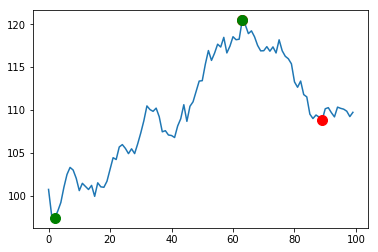

In [8]:
# Test cumulative drawdowns and pulls
n = 100
r_w = np.random.randn(n).cumsum() + 100
l_dd, h_dd, l_p, h_p = max_draw_pull(r_w)

plt.plot(r_w)
plt.plot(
    [l_dd, h_dd], 
    [r_w[l_dd], r_w[h_dd],], 
    'o', color='Red', markersize=10)
plt.plot(
    [l_p, h_p], 
    [r_w[l_p], r_w[h_p]], 
    'o', color='Green', markersize=10)

In [1103]:
# Retrieves historical pricing
secpx = get_symbol_pricing(symbol, freq)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

In [1110]:
fwd_ss_ret = lambda x, df, arr: df.loc[[y for y in arr[x-1] if y in df.index.tolist()]].mean()

In [1111]:
# seasonality analysis
ss_df = closepx.pct_change().resample('M').sum().to_frame()
ss_df['year'], ss_df['month'] = ss_df.index.year, ss_df.index.month
ss_df = ss_df.pivot_table(index='year', columns='month').mean()
ss_pos = [(x, (x+1) if not (x+1) // 12 else 0, 
     x+2 if not (x+2) // 12 else x - 10) for x in range(12)]

# [fwd_ss_ret(x+1, ss_df['close'], ss_pos) for x in range(12)] # test

In [1112]:
# apply seasonality, mean return of curr month plus next two
secpx['month'] = secpx.index.month
secpx['fwdSSRet'] = secpx.loc[:].month.apply(
    fwd_ss_ret, args=(ss_df['close'], ss_pos,))

In [ ]:
secpx.columns # all columns

In [ ]:
# normalized columns for ML training, still has outliers
ml_ds_cols = secpx.describe().loc['50%'][secpx.describe().loc['50%'] < 5].index.tolist()
ml_ds_cols

In [ ]:
# prepare ML dataset
ml_ds = secpx[ml_ds_cols].copy()

class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
cut_range = [-1, -0.05, .0, .02, .09, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

for c in class_cols: ml_ds[c] = pd.cut(secpx[c], cut_range, labels=fwd_ret_labels)
ml_ds.info()

In [ ]:
# drop the predicting class with most nas
ml_ds.dropna(inplace=True)
ml_ds.info()

In [ ]:
ml_ds.hist(figsize=(15,15));

In [622]:
ml_ds.to_csv(csv_ext.format('co_price_mom_ds'), index=False)